In [56]:
import os
from pprint import pprint

import numpy as np
import IPython.display
from tqdm import tqdm
import PIL
from PIL import Image

import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras import Model
from tensorflow.keras.layers import (Input, Conv2D, MaxPooling2D, Reshape, Dense, GRU, Activation,
                                     Lambda)
from tensorflow.keras.optimizers import RMSprop

import numpy as np

In [57]:
HERE = "."
path_img_folder = os.path.join(HERE, "data", "img") + "/."
path_dot_folder = os.path.join(HERE, "data", "dot") + "/."

IMG_HEIGHT = 299
IMG_WIDTH = 299

In [58]:
def simplify_dot(path_dot_file):
    with open(path_dot_file, "r") as f:
        s = f.read()
        s = s.replace("->", ">")
        s = s.replace(" ", "")
        s = s.replace("\t", "")
        s = s.replace("\n", "")
        s = s.split('""')[-1]
    return s


def test_simplify_dot():
    fname_img = "r-1_h-1_nsh-circle_l-circo_ah-normal.png"
    fname_dot = "_".join(fname_img.split("_")[:2]) + ".dot"

    path_fname_dot = os.path.join(HERE, "data", "dot", fname_dot)

    s = simplify_dot(path_fname_dot)
    print(s)

test_simplify_dot()

{0>1;}


In [59]:
def convert_dot(path_dot_folder):
    for fname in tqdm(os.listdir(path_dot_folder)):
        if fname[-4:] == ".dot" and fname[:2] != "s_":
            with open(os.path.join(path_dot_folder, "s_" + fname), "w") as f:
                f.write(simplify_dot(os.path.join(path_dot_folder, fname)))


def test_convert_dot():
    path_dot_folder = os.path.join(HERE, "data", "dot") + "/."
    convert_dot(path_dot_folder)

test_convert_dot()

100%|██████████| 20/20 [00:00<00:00, 2554.62it/s]


In [60]:
def get_max_dim(path_img_folder):
    max_height, max_width = 0, 0
    for fname_img in tqdm(os.listdir(path_img_folder)):
        if fname_img[-4:] == ".png":
            path_img_file = os.path.join(path_img_folder, fname_img)
            img = tf.io.read_file(path_img_file)
            img = tf.image.decode_png(img, channels=3)
            shp = np.shape(img.numpy())
            max_height = max(shp[0], max_height)
            max_width = max(shp[1], max_width)
    return max_height, max_width
max_height, max_width = get_max_dim(path_img_folder)
print("MAX Height: ", max_height)
print("MAX Width : ", max_width)

100%|██████████| 751/751 [00:00<00:00, 1127.98it/s]

MAX Height:  766
MAX Width :  1360


In [61]:
def get_max_len(path_dot_folder):
    max_len = 0
    for fname_dot in tqdm(os.listdir(path_dot_folder)):
        if fname_dot[:2] == "s_":
            path_dot_file = os.path.join(path_dot_folder, fname_dot)
            with open(path_dot_file, "r") as f:
                s = f.read()
            max_len = max(len(s), max_len)
    return max_len
absolute_max_string_len = get_max_len(path_dot_folder)
print("Absolute MAX string length: ", absolute_max_string_len)

100%|██████████| 20/20 [00:00<00:00, 13514.75it/s]

Absolute MAX string length:  43


In [62]:
def convert_img(path_img_file):
    img = tf.io.read_file(path_img_file)
    img = tf.image.decode_png(img, channels=3)
    img = tf.image.transpose(img)
    img = tf.constant(255, dtype=tf.uint8) - img
    img = tf.image.resize_with_pad(img, target_height=max_height, target_width=max_width)
    img = tf.image.resize(img, (IMG_HEIGHT, IMG_WIDTH))
#     img = tf.keras.applications.inception_v3.preprocess_input(img)
    img = img.numpy()
    return img

def test_convert_img():
    path_img_folder = os.path.join(HERE, "img") + "/."
    convert_img(path_img_folder)

In [63]:
def generate_dataset(path_img_folder, path_dot_folder):
    convert_dot(path_dot_folder)

    img_data, label_data = [], []
    for fname_img in tqdm(os.listdir(path_img_folder)):
        if fname_img[-4:] == ".png":
            conv_img = convert_img(os.path.join(path_img_folder, fname_img))
            fname_dot = "s_" + "_".join(fname_img.split("_")[:2]) + ".dot"
            with open(os.path.join(path_dot_folder, fname_dot), "r") as f:
                s_dot = f.read()
                img_data.append(conv_img)
                label_data.append(s_dot)
    return img_data, label_data


def get_data():
    data = generate_dataset(path_img_folder, path_dot_folder)
    return data

if __name__ == "__main__":
    data = get_data()
    print(np.shape(data[0][0]))

100%|██████████| 751/751 [00:08<00:00, 88.68it/s]

(299, 299, 3)


In [64]:
def showimg(imgarr):
    img = np.uint8(imgarr)
    IPython.display.display(PIL.Image.fromarray(img))

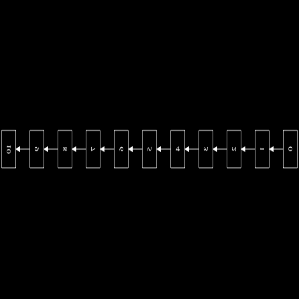

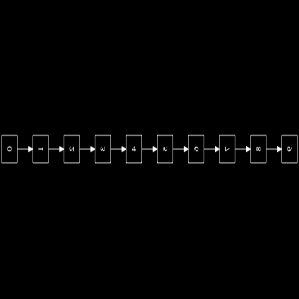

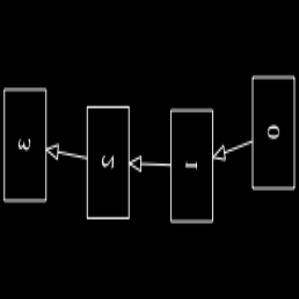

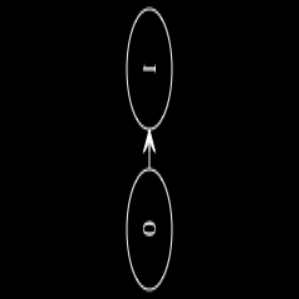

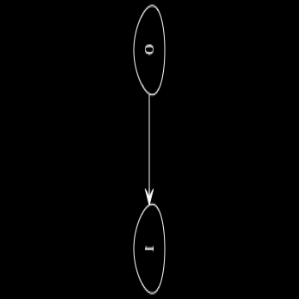

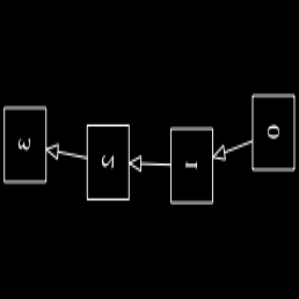

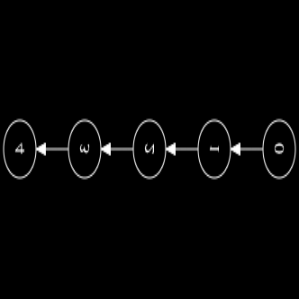

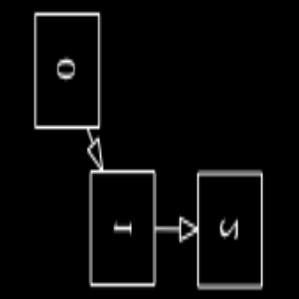

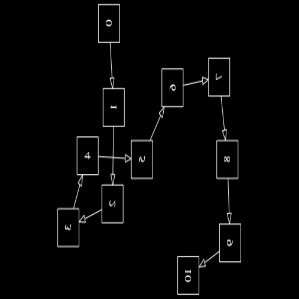

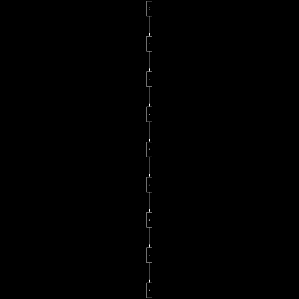

In [65]:
for i in range(10):
    showimg(data[0][i])

In [67]:
alphabet = list({e for s in data[1] for e in s})
alphabet.sort()
alphabet = "".join(alphabet)
print("ALPHABET: ", alphabet)
print("ALPHABET SIZE: ", len(alphabet))

ALPHABET:  0123456789;>{}
ALPHABET SIZE:  14


In [68]:
# alphabet = "abcdefghijklmnopqrstuvwxyz "
# absolute_max_string_len = 10

def get_output_size():
        return len(alphabet) + 1
    
blank_label = get_output_size() - 1

print("Alphabet size: ", get_output_size())
print("Max string length: ", absolute_max_string_len)

Alphabet size:  15
Max string length:  43


In [69]:
def text_to_labels(text):
    ret = []
    for char in text:
        ret.append(alphabet.find(char))
    return ret

def labels_to_text(labels):
    ret = []
    for c in labels:
        if c == len(alphabet):  # CTC Blank
            ret.append("")
        else:
            ret.append(alphabet[c])
    print(ret)
    return "".join(ret)

In [15]:
def ctc_lambda_func(args):
    y_pred, labels, input_length, label_length = args
    # the 2 is critical here since the first couple outputs of the RNN
    # tend to be garbage:
    y_pred = y_pred[:, 2:, :]
    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)

In [29]:
IMG_WIDTH = 299
IMG_HEIGHT = 299
pool_size = 2
downsample_factor=(pool_size ** 2)

def create_model():
    img_w = IMG_WIDTH
    img_h = IMG_HEIGHT
    # Network parameters
    conv_filters = 16
    kernel_size = (3, 3)
    time_dense_size = 32
    rnn_size = 512
    minibatch_size = 1  # 32

    input_shape = (img_w, img_h, 3)

    act = "relu"
    input_data = Input(name="the_input", shape=input_shape, dtype="float32")
    inner = Conv2D(
        conv_filters,
        kernel_size,
        padding="same",
        activation=act,
        kernel_initializer="he_normal",
        name="conv1",
    )(input_data)
    inner = MaxPooling2D(pool_size=(pool_size, pool_size), name="max1")(inner)
    inner = Conv2D(
        conv_filters,
        kernel_size,
        padding="same",
        activation=act,
        kernel_initializer="he_normal",
        name="conv2",
    )(inner)
    inner = MaxPooling2D(pool_size=(pool_size, pool_size), name="max2")(inner)

    conv_to_rnn_dims = (
        img_w // (pool_size ** 2),
        (img_h // (pool_size ** 2)) * conv_filters,
    )
    inner = Reshape(target_shape=conv_to_rnn_dims, name="reshape")(inner)

    # cuts down input size going into RNN:
    inner = Dense(time_dense_size, activation=act, name="dense1")(inner)

    # Two layers of bidirectional GRUs
    # GRU seems to work as well, if not better than LSTM:
    # data shape input: (batch_size, timesteps, ...)
    # data output size: (batch_size, timesteps, output_size)
    gru_1 = GRU(
        rnn_size, return_sequences=True, kernel_initializer="he_normal", name="gru1"
    )(inner)
    gru_1b = GRU(
        rnn_size,
        return_sequences=True,
        go_backwards=True,
        kernel_initializer="he_normal",
        name="gru1_b",
    )(inner)
    gru1_merged = tf.keras.layers.add([gru_1, gru_1b])
    gru_2 = GRU(
        rnn_size, return_sequences=True, kernel_initializer="he_normal", name="gru2"
    )(gru1_merged)
    gru_2b = GRU(
        rnn_size,
        return_sequences=True,
        go_backwards=True,
        kernel_initializer="he_normal",
        name="gru2_b",
    )(gru1_merged)

    # transforms RNN output to character activations:
    inner = Dense(
        get_output_size(), kernel_initializer="he_normal", name="dense2"
    )(tf.keras.layers.concatenate([gru_2, gru_2b]))
    y_pred = Activation("softmax", name="softmax")(inner)
    model = Model(inputs=input_data, outputs=y_pred)

    labels = Input(
        name="the_labels", shape=[absolute_max_string_len], dtype="float32"
    )
    input_length = Input(name="input_length", shape=[1], dtype="int64")
    label_length = Input(name="label_length", shape=[1], dtype="int64")
    # Keras doesn't currently support loss funcs with extra parameters
    # so CTC loss is implemented in a lambda layer
    loss_out = Lambda(ctc_lambda_func, output_shape=(1,), name="ctc")(
        [y_pred, labels, input_length, label_length]
    )

    # clipnorm seems to speeds up convergence
    # sgd = SGD(lr=0.02, decay=1e-6, momentum=0.9, nesterov=True)

    model_and_loss = Model(
        inputs=[input_data, labels, input_length, label_length], outputs=loss_out
    )
    
    
    sgd = RMSprop(lr=0.001, rho=0.9)
    
    model_and_loss.compile(
        loss={"ctc": lambda y_true, y_pred: y_pred},
        optimizer=sgd)

    # captures output of softmax so we can decode the output during visualization
    test_func = K.function([input_data], [y_pred])
    
    return model, model_and_loss, test_func

In [30]:
model, model_and_loss, test_func = create_model()
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
the_input (InputLayer)          [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 299, 299, 16) 448         the_input[0][0]                  
__________________________________________________________________________________________________
max1 (MaxPooling2D)             (None, 149, 149, 16) 0           conv1[0][0]                      
__________________________________________________________________________________________________
conv2 (Conv2D)                  (None, 149, 149, 16) 2320        max1[0][0]                       
____________________________________________________________________________________________

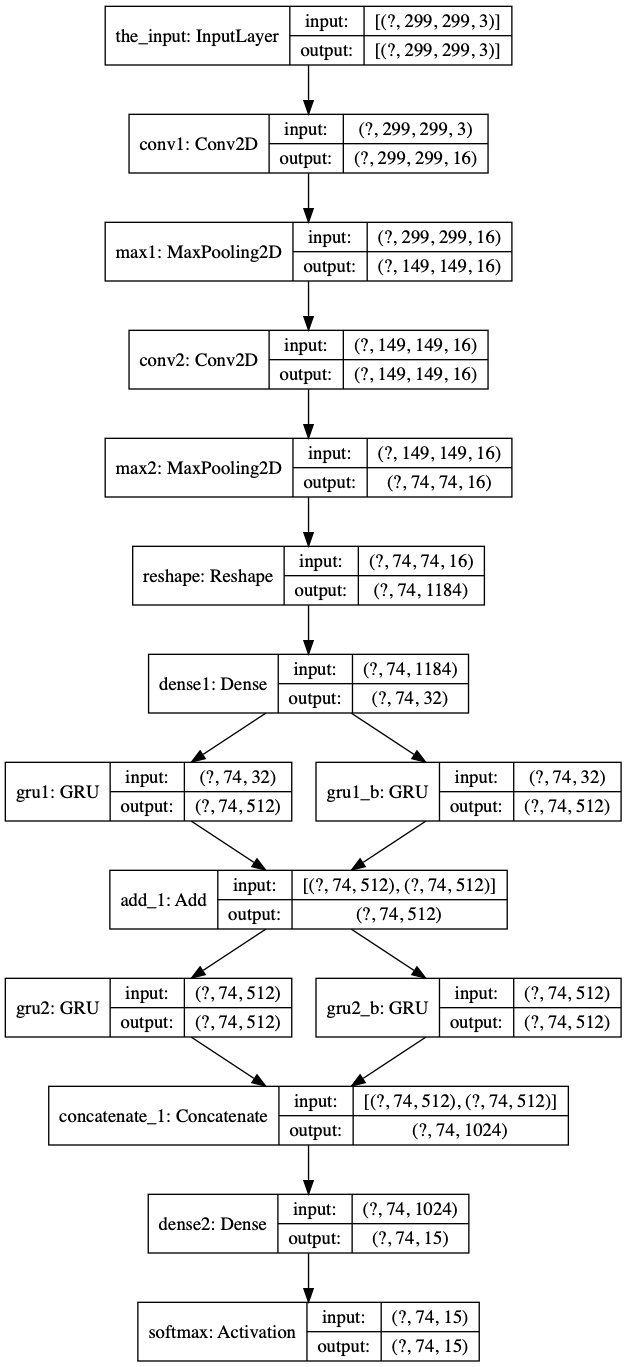

In [31]:
tf.keras.utils.plot_model(model, show_shapes=True)

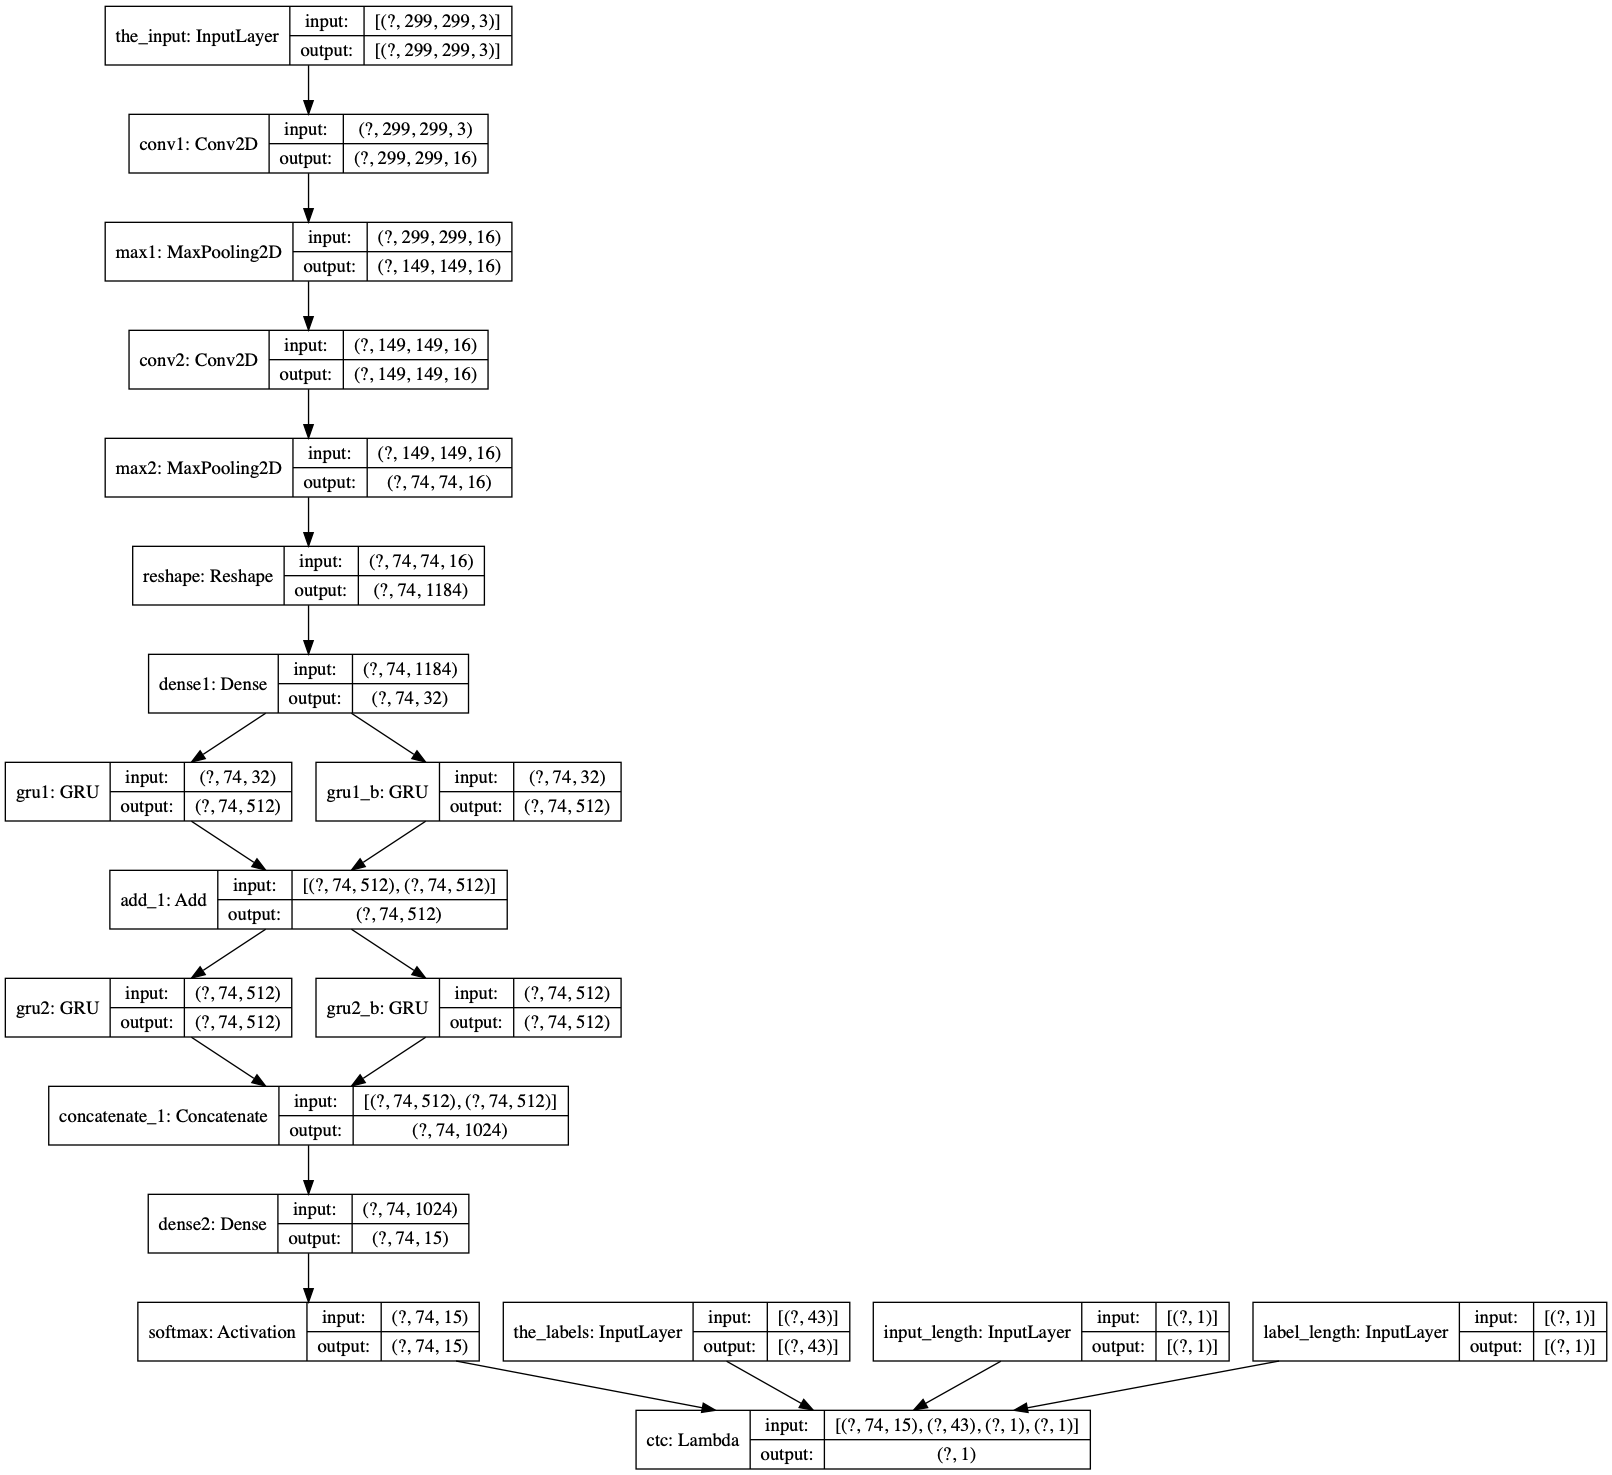

In [32]:
tf.keras.utils.plot_model(model_and_loss, show_shapes=True)

In [45]:
# res = model.predict([the_input_data, the_labels_data, input_length_data, label_length_data])
import itertools
def decode_batch(test_func, word_batch):
    """Decode a batch of input:
    
    Args:
        test_func (callable): test_func([word_batch])
        word_batch: input with shape (batch_size, img_width, img_hight, channels) such as (1, 100, 10, 1).
    Returns:
    """
    out = test_func([word_batch])# [0]
    ret = []
    for j in range(out.shape[0]):
        out_best = list(np.argmax(out[j, 2:], 1))
        out_best = [k for k, g in itertools.groupby(out_best)]
        outstr = labels_to_text(out_best)
        ret.append(outstr)
    return ret

# decode_batch(model.predict, the_input_data)

In [76]:
def training_data():
    size = np.shape(data[0])[0]
    
    input_data = np.array(data[0])
    
    labels = np.ones([size, absolute_max_string_len]) * -1
    input_length = np.zeros([size, 1])
    labels_length = np.zeros([size, 1])
    for i, string in enumerate(data[1]):
        labels[i, 0:len(string)] = text_to_labels(string) 
        input_length[i] = IMG_WIDTH // downsample_factor - 2
        labels_length[i] = len(string)
    
    print("input_data shape: ", np.shape(input_data))
    print("labels shape: ", np.shape(labels))
    print("input_length shape: ", np.shape(input_length))
    print("labels_length shape: ", np.shape(labels_length))
    
    res = [
        input_data,
        labels,
        input_length,
        labels_length 
    ]
    return res

In [77]:
data = training_data()

input_data shape:  (751, 299, 299, 3)
labels shape:  (751, 43)
input_length shape:  (751, 1)
labels_length shape:  (751, 1)


In [78]:
def train(epochs):

    # the loss calc occurs elsewhere, so use a dummy lambda func for the loss
    model_and_loss.fit(
        data,
        np.zeros([np.shape(data[0])[0]]),
#         steps_per_epoch=10,  # (words_per_epoch - val_words) // minibatch_size,
        batch_size=32,
        epochs=epochs,
    )


In [79]:
train(10)

Train on 751 samples
Epoch 1/10
751/751 [==============================] - 46s 61ms/sample - loss: 3.1858
Epoch 2/10
751/751 [==============================] - 49s 66ms/sample - loss: 3.7733
Epoch 3/10
751/751 [==============================] - 64s 85ms/sample - loss: 3.2095
Epoch 4/10
751/751 [==============================] - 51s 68ms/sample - loss: 2.6496
Epoch 5/10
751/751 [==============================] - 61s 82ms/sample - loss: 2.1154
Epoch 6/10
751/751 [==============================] - 55s 73ms/sample - loss: 1.7517
Epoch 7/10
751/751 [==============================] - 57s 76ms/sample - loss: 1.1963
Epoch 8/10
751/751 [==============================] - 54s 72ms/sample - loss: 1.6004
Epoch 9/10
751/751 [==============================] - 57s 76ms/sample - loss: 2.2902
Epoch 10/10
751/751 [==============================] - 55s 73ms/sample - loss: 1.0060


In [80]:
pred = model.predict(data[0][:1])

In [81]:
np.shape(pred)

(1, 74, 15)

In [82]:
decode_batch(model.predict, data[0][:1])

['{', '0', '>', '1', ';', '1', '>', '2', ';', '2', '>', '3', ';', '3', '>', '4', ';', '4', '>', '5', ';', '5', '>', '6', ';', '6', '>', '7', ';', '7', '>', '8', ';', '8', '>', '9', ';', '9', '>', '1', '0', ';', '}']


['{0>1;1>2;2>3;3>4;4>5;5>6;6>7;7>8;8>9;9>10;}']

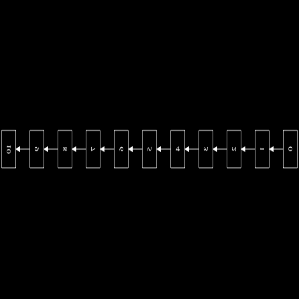

In [83]:
showimg(data[0][0])

In [84]:
model_and_loss.save_weights("weights.h5")

In [87]:
def convert_from_jpg(path_img_file):
    img = tf.io.read_file(path_img_file)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.transpose(img)
    img = tf.constant(255, dtype=tf.uint8) - img
    img = tf.image.resize_with_pad(img, target_height=max_height, target_width=max_width)
    img = tf.image.resize(img, (IMG_HEIGHT, IMG_WIDTH))
#     img = tf.keras.applications.inception_v3.preprocess_input(img)
    img = img.numpy()
    return img

In [88]:
img_test = convert_from_jpg("img_test.jpg")

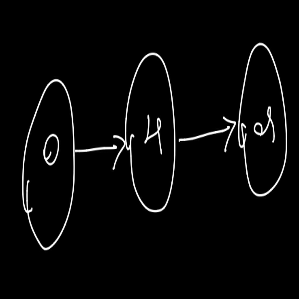

In [89]:
showimg(img_test)

In [90]:
decode_batch(model.predict, [img_test])

['{', '0', '>', '1', ';', '>', '3', ';', '>', ';', '}']


['{0>1;>3;>;}']